In [56]:
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

############################################ Lecture des fichiers ######################################
##################################### Préparation et analyse des données ###############################

mobilisation = pd.read_csv("LFB Mobilisation data Last 3 years.csv", header=0, sep=";");
incident = pd.read_csv("LFB Incident data Last 3 years.csv", header=0, sep=";");

df_merge = pd.merge(incident, mobilisation, on='IncidentNumber')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587073 entries, 0 to 587072
Data columns (total 59 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   IncidentNumber                          587073 non-null  object 
 1   DateOfCall                              587073 non-null  object 
 2   CalYear_x                               587073 non-null  int64  
 3   TimeOfCall                              587073 non-null  object 
 4   HourOfCall_x                            587073 non-null  int64  
 5   IncidentGroup                           587073 non-null  object 
 6   StopCodeDescription                     587073 non-null  object 
 7   SpecialServiceType                      125417 non-null  object 
 8   PropertyCategory                        587073 non-null  object 
 9   PropertyType                            587073 non-null  object 
 10  AddressQualifier                        5870

In [57]:
#On contrôle le pourcentage de valeurs manquantes
df_merge.isna().sum()/len(df_merge)*100

# On supprime les variables qui ont plus de 50% de valeurs manquantes et qui représente
# un intérêt mineur pour l'apprentissage du modele et pour l'intérprétation du résulat final.
# On fait une exception pour la variable SpecialServiceType qui sera re-travaillée plus tard
df_merge = df_merge.drop(["Postcode_full", "Easting_m", "Northing_m", "Latitude", "Longitude", "DelayCodeId", "DelayCode_Description","DateAndTimeReturned"], axis = 1)
#df_merge = df_merge.dropna()

#### On scinde le dataset en 2 groupes ####
#### Variables indicatrices et categorielles ####
df_indicatrice = df_merge.select_dtypes(include=['int64','float64'])
df_categorielle = df_merge.select_dtypes(include=['object'])

#print(df_indicatrice.info())
#print(df_categorielle.info())

In [58]:
# La variable IncidentNumber ne eprésnte pas de notion métier donc peu influente sur
# l'aprentissage et sur l'analyse du résultat final
df_categorielle = df_categorielle.drop("IncidentNumber", axis = 1)
df_categorielle.columns

Index(['DateOfCall', 'TimeOfCall', 'IncidentGroup', 'StopCodeDescription',
       'SpecialServiceType', 'PropertyCategory', 'PropertyType',
       'AddressQualifier', 'Postcode_district', 'UPRN', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode',
       'IncGeo_WardName', 'IncGeo_WardNameNew', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation', 'Resource_Code',
       'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile',
       'DateAndTimeArrived', 'DateAndTimeLeft', 'DeployedFromStation_Code',
       'DeployedFromStation_Name', 'DeployedFromLocation', 'PlusCode_Code',
       'PlusCode_Description'],
      dtype='object')

In [59]:
# On regarde les valeurs pour analyse
df_categorielle.sample()


,DateOfCall,TimeOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_district,UPRN,...,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,DateAndTimeLeft,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PlusCode_Code,PlusCode_Description
93267,09 Aug 2018,11:57:52,Special Service,Special Service,Flooding,Non Residential,Purpose built office,Correct incident location,TW8,10091693501,...,1,09/08/2018 10:57:52,09/08/2018 11:01:24,09/08/2018 11:04:21,09/08/2018 11:10:44,G38,Heston,Home Station,Initial,Initial Mobilisation


In [60]:
# On supprime les notions de date et heures en doublon pour ne conserver que celles utiles
# pour l'appretissage du modèle et pour l'intérprétation du résultat final
# On conserve les variables DateAndTimeMobilised et DateAndTimeArrived pour faire 
# une intérprétation sur le délai d'intervention du résultat final 
df_categorielle = df_categorielle.drop(['DateOfCall', 'TimeOfCall', 'DateAndTimeMobile', 'DateAndTimeLeft'], axis = 1)


Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

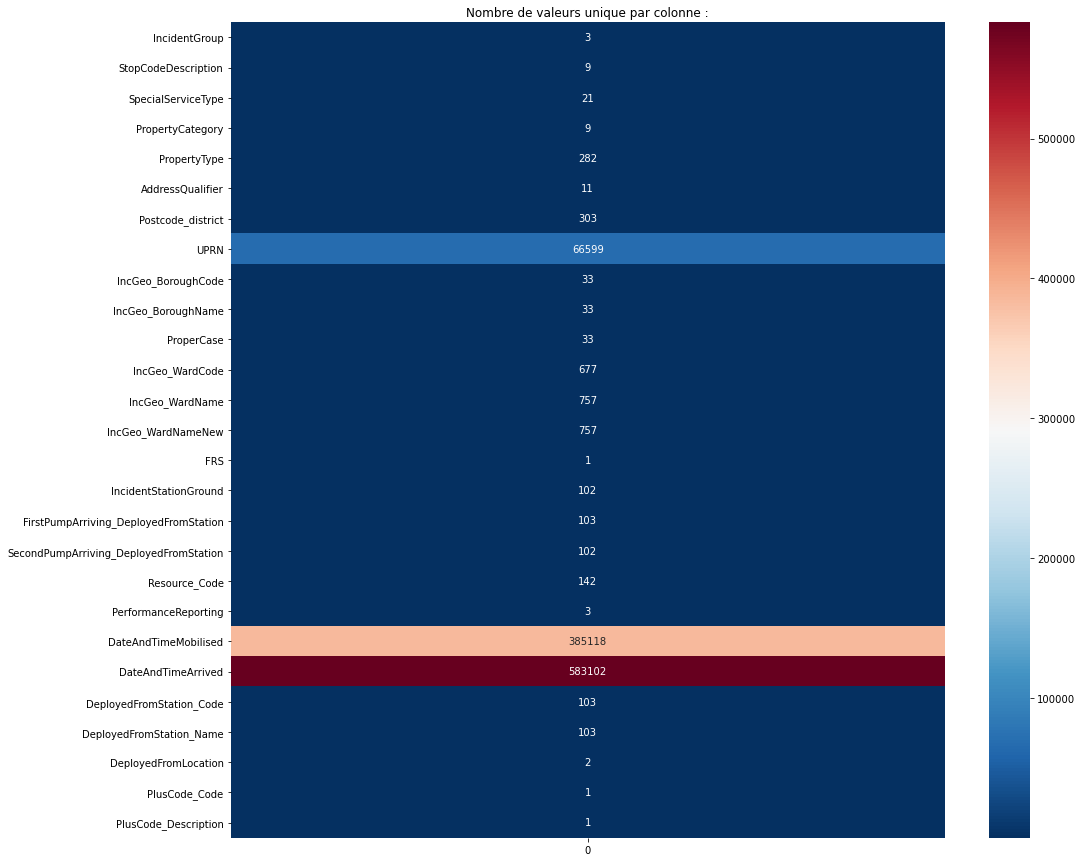

In [61]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [62]:
# Aprés observation de La variable UPRN on constate qu'il existe beaucoup de modalité
# et pour éviter un sur apprentissage sur cette variable et pour uniformiser le modèle 
# d'apprentissage nous préférons supprimer cette variable qui ne représente pas une 
# information importante pour notre objectif
df_categorielle = df_categorielle.drop("UPRN", axis = 1)

print(df_categorielle["IncGeo_WardName"].value_counts())
print(df_categorielle["IncGeo_WardNameNew"].value_counts())

WEST END            7631
ST. JAMES'S         7268
CHURCH STREET       4373
REGENT'S PARK       4275
LEWISHAM CENTRAL    3843
                    ... 
Chadwell Heath         1
New Cross              1
Knight's Hill          1
NUNHEAD                1
WANSTEAD               1
Name: IncGeo_WardName, Length: 757, dtype: int64
WEST END            7631
ST. JAMES'S         7268
CHURCH STREET       4373
REGENT'S PARK       4275
LEWISHAM CENTRAL    3843
                    ... 
Chadwell Heath         1
New Cross              1
Knight's Hill          1
NUNHEAD                1
WANSTEAD               1
Name: IncGeo_WardNameNew, Length: 757, dtype: int64


In [64]:
# On constate qu'il existe aussi un décalage du nombre de modalités avec les variables
# IncGeo_WardName, IncGeo_WarNameNew et IncGeo_WardCode
# Nous décidons de garder qu'une seule variable entre IncGeo_WardName et IncGeo_WardNameNew
# On contrôle si il existe des valeurs différentes entre les 2 variables
df_categorielle[df_categorielle["IncGeo_WardName"] != df_categorielle["IncGeo_WardNameNew"]]

# Une seule ligne est remontée mais comme on part du principe que la nouvelle valeur sera plus fiable
# donc on décide de supprimer la variable IncGeo_WardName
df_categorielle = df_categorielle.drop("IncGeo_WardName", axis = 1)

KeyError: 'IncGeo_WardName'

In [65]:
print(df_categorielle["IncGeo_WardNameNew"].head())
print(df_categorielle["IncGeo_WardNameNew"].value_counts())
print(df_categorielle["IncGeo_WardCode"].head())
print(df_categorielle["IncGeo_WardCode"].value_counts())

# Aprés analyse on constate qu'il est préférable de garder la variable "IncGeo_WardNameNew" pour une
# meilleure intérprétation des résultats alors que la variable "IncGeo_WardCode" sera moins représentative 
# lors de l'intérprétation de plus celle-ci possède des valeurs manquantes.
df_categorielle = df_categorielle.drop("IncGeo_WardCode", axis = 1)


0    EAST FINCHLEY
1        SANDS END
2        SANDS END
3     STROUD GREEN
4         COLVILLE
Name: IncGeo_WardNameNew, dtype: object
WEST END            7631
ST. JAMES'S         7268
CHURCH STREET       4373
REGENT'S PARK       4275
LEWISHAM CENTRAL    3843
                    ... 
Chadwell Heath         1
New Cross              1
Knight's Hill          1
NUNHEAD                1
WANSTEAD               1
Name: IncGeo_WardNameNew, Length: 757, dtype: int64
0    E05000049
1    E05000262
2    E05000262
3    E05000279
4    E05009392
Name: IncGeo_WardCode, dtype: object
E05000649    7631
E05000644    7268
E05000634    4373
E05000448    3843
E05000138    3753
             ... 
E05000149       1
E05000515       1
E05000076       1
E05000545       1
E05000499       1
Name: IncGeo_WardCode, Length: 677, dtype: int64


Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

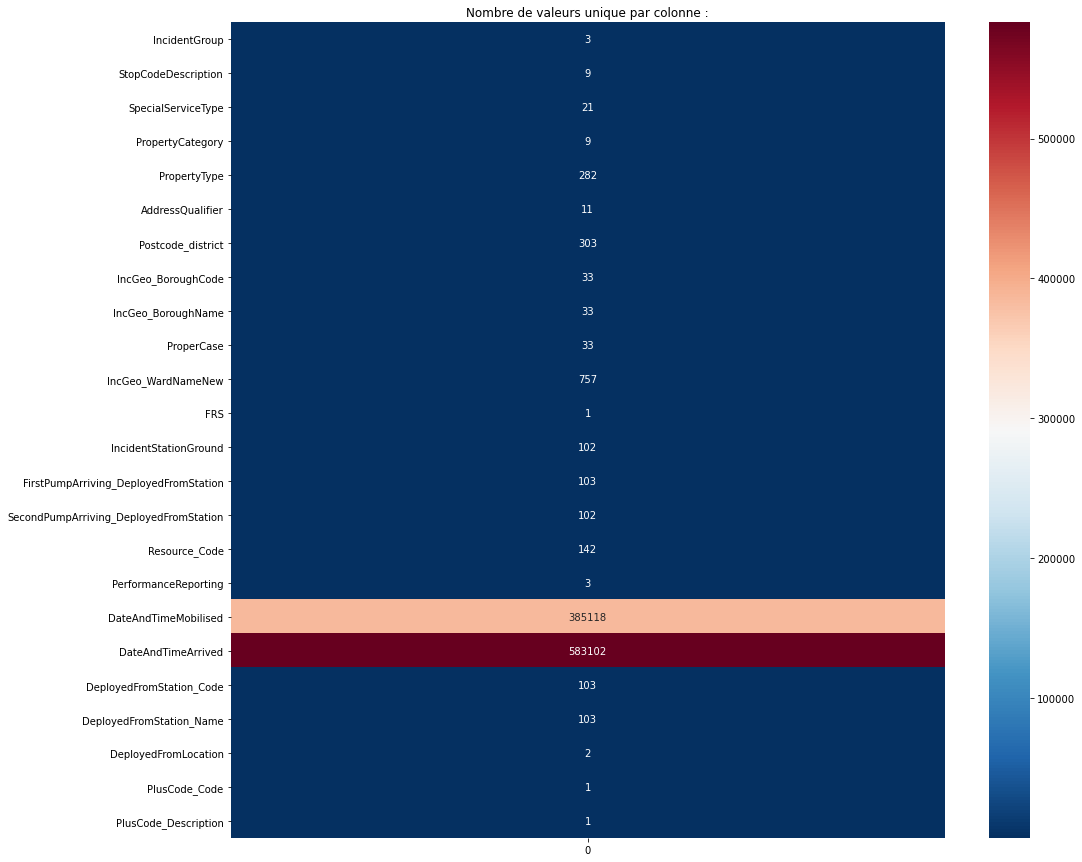

In [66]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [33]:
print(df_categorielle["FRS"].head())
print(df_categorielle["PlusCode_Code"].head())
print(df_categorielle["PlusCode_Description"].head())
print(df_categorielle["FRS"].value_counts())


0    London
1    London
2    London
3    London
4    London
Name: FRS, dtype: object
0    Initial
1    Initial
2    Initial
3    Initial
4    Initial
Name: PlusCode_Code, dtype: object
0    Initial Mobilisation
1    Initial Mobilisation
2    Initial Mobilisation
3    Initial Mobilisation
4    Initial Mobilisation
Name: PlusCode_Description, dtype: object
London    587073
Name: FRS, dtype: int64


In [67]:
# Aprés l'analyse de la heatmap ci-dessus on constate 3 variables qui possède une seule modalité
# "FRS", "PlusCode_Code", "PlusCode_Description" comme celles-ci ne représente pas une information 
# capitale pour l'apprentissage du modèle et qu'il existe qu'une seule modalité on decide de les supprimer
df_categorielle = df_categorielle.drop(["FRS", "PlusCode_Code", "PlusCode_Description"], axis = 1)

# On peut constater que la variable "PropertyType" possède beaucoup de modalité comparé aux autres variables
# on essaie d'analyser le contenu de la variable pour déterminer si on la conserve ou pas
print(df_categorielle["PropertyType"].head())
print(df_categorielle["PropertyCategory"].head())
print(df_categorielle["PropertyCategory"].value_counts())
print(df_categorielle["PropertyType"].value_counts())


0                                              Mosque 
1    Purpose Built Flats/Maisonettes - Up to 3 stor...
2    Purpose Built Flats/Maisonettes - Up to 3 stor...
3       Converted Flat/Maisonettes - 3 or more storeys
4       Converted Flat/Maisonettes - 3 or more storeys
Name: PropertyType, dtype: object
0    Non Residential
1           Dwelling
2           Dwelling
3           Dwelling
4           Dwelling
Name: PropertyCategory, dtype: object
Dwelling             339038
Non Residential      106876
Outdoor               39818
Other Residential     39663
Road Vehicle          36814
Outdoor Structure     23299
Rail Vehicle            642
Boat                    493
Aircraft                430
Name: PropertyCategory, dtype: int64
Purpose Built Flats/Maisonettes - 4 to 9 storeys         89496
House - single occupancy                                 70075
Purpose Built Flats/Maisonettes - Up to 3 storeys        59056
Self contained Sheltered Housing                         37269
Purpose

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

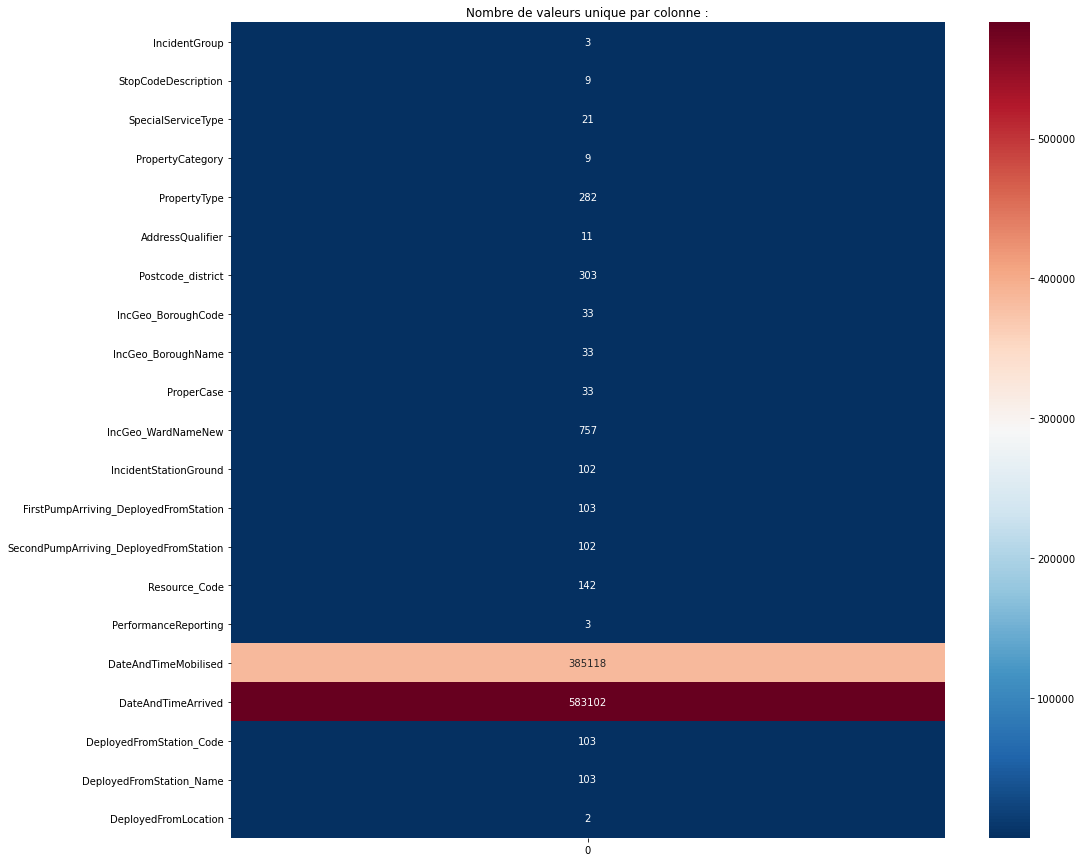

In [68]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [69]:
# On peut voir que l'on peut retrouver le même de type d'information dans la variable "PropertyCategory"
# et de manière à uniformiser le nombre de moyen de modalité sur l'ensemble du jeu de données on décide
# de supprimer la variable "PropertyType" 
df_categorielle = df_categorielle.drop("PropertyType", axis = 1)


In [39]:
print(df_categorielle["SecondPumpArriving_DeployedFromStation"].head())
print(df_categorielle["DeployedFromStation_Code"].head())
print(df_categorielle["Postcode_district"].head())
print(df_categorielle["Resource_Code"].value_counts())

0           NaN
1       Chelsea
2       Chelsea
3           NaN
4    Kensington
Name: SecondPumpArriving_DeployedFromStation, dtype: object
0    A39
1    H33
2    G34
3    A32
4    G27
Name: DeployedFromStation_Code, dtype: object
0     N2
1    SW6
2    SW6
3     N8
4    W11
Name: Postcode_district, dtype: object
A242    12021
A231    10445
F241     8834
G341     8802
A241     8383
        ...  
H411     1594
E411     1553
H261     1310
F401      995
E421      619
Name: Resource_Code, Length: 142, dtype: int64


In [70]:
# Il est préférable de conserver dans la pluspart des cas l'information littérale plutôt
# qu'un nombre qui n'a pas trop de signification par conséquent on décide de supprimer
# les variables "SecondPumpArriving_DeployedFromStation", "DeployedFromStation_Code", "Postcode_district"
# On décide cependant de conserver le "Resource_Code" qui représente la brigade qui a intervenu pour donner 
# une plus value à l'intérprétation des résultats
df_categorielle = df_categorielle.drop(["SecondPumpArriving_DeployedFromStation", "DeployedFromStation_Code", "Postcode_district"], axis = 1)

df_categorielle.columns

Index(['IncidentGroup', 'StopCodeDescription', 'SpecialServiceType',
       'PropertyCategory', 'AddressQualifier', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardNameNew',
       'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation',
       'Resource_Code', 'PerformanceReporting', 'DateAndTimeMobilised',
       'DateAndTimeArrived', 'DeployedFromStation_Name',
       'DeployedFromLocation'],
      dtype='object')

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

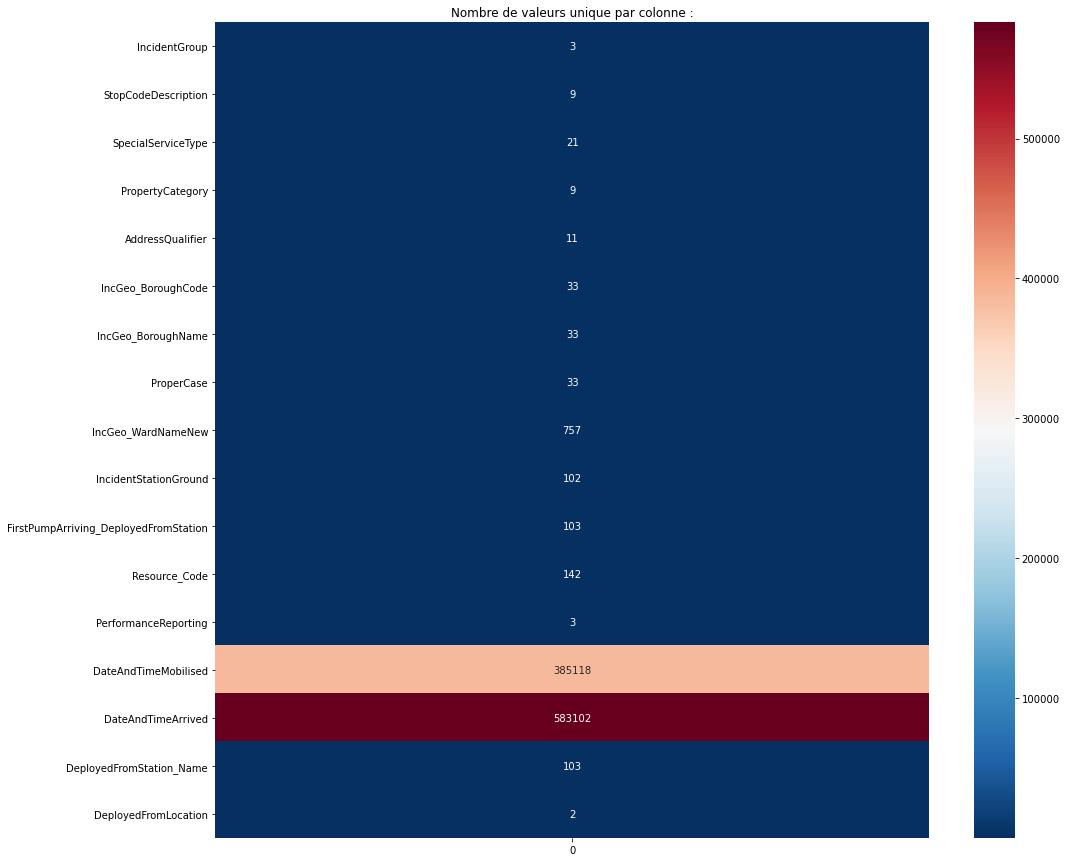

In [71]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [72]:
df_categorielle.head()

print(df_categorielle["DeployedFromLocation"].value_counts())
print(df_categorielle["PerformanceReporting"].value_counts())
print(df_categorielle["PerformanceReporting"].head())

Home Station     565310
Other Station     21427
Name: DeployedFromLocation, dtype: int64
1           375862
2           152067
Not Used     59144
Name: PerformanceReporting, dtype: int64
0    1
1    1
2    2
3    1
4    1
Name: PerformanceReporting, dtype: object


In [73]:
# On décide de transformer la variable "DeployedFromLocation" en variable indicatrice au regard de la répartition
# des modalités ci-dessus
df_categorielle["DeployedFromLocation"] = df_categorielle["DeployedFromLocation"].replace(["Home Station", "Other Station"], [0,1])

# On remplace la valeur "Not Used" par 0
df_categorielle["PerformanceReporting"] = df_categorielle["PerformanceReporting"].replace({"Not Used" : 0})

In [74]:
print(df_categorielle["DeployedFromLocation"].value_counts())
print(df_categorielle[["IncGeo_BoroughName", "IncGeo_BoroughCode", "ProperCase", "IncGeo_WardNameNew"]])

0.0    565310
1.0     21427
Name: DeployedFromLocation, dtype: int64
            IncGeo_BoroughName IncGeo_BoroughCode              ProperCase  \
0                       BARNET          E09000003                  Barnet   
1       HAMMERSMITH AND FULHAM          E09000013  Hammersmith And fulham   
2       HAMMERSMITH AND FULHAM          E09000013  Hammersmith And fulham   
3                     HARINGEY          E09000014                Haringey   
4       KENSINGTON AND CHELSEA          E09000020  Kensington And chelsea   
...                        ...                ...                     ...   
587068                LEWISHAM          E09000023                Lewisham   
587069                LEWISHAM          E09000023                Lewisham   
587070                   BRENT          E09000005                   Brent   
587071                   BRENT          E09000005                   Brent   
587072                   BRENT          E09000005                   Brent   

      

In [75]:
# Il existe une redondance d'information avec l'arrondissement où l'incident à eu lieu entre les variables
# "IncGeo_BoroughName", "ProperCase" et comme le code de l'arrondissement ne signifie pas
# une information capitale pour l'intérprétation finale on décide de le supprimer pour ne garder que la variable 
# "ProperCase"
df_categorielle = df_categorielle.drop(["IncGeo_BoroughName", "IncGeo_BoroughCode"], axis = 1)


In [77]:
# Variables indicatrices
df_categorielle.head()


,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,AddressQualifier,ProperCase,IncGeo_WardNameNew,IncidentStationGround,FirstPumpArriving_DeployedFromStation,Resource_Code,PerformanceReporting,DateAndTimeMobilised,DateAndTimeArrived,DeployedFromStation_Name,DeployedFromLocation
0,False Alarm,AFA,NaN,Non Residential,Within same building,Barnet,EAST FINCHLEY,Finchley,Finchley,A392,1,01/01/2018 00:04:25,01/01/2018 00:10:13,Finchley,0.0
1,Special Service,Special Service,Flooding,Dwelling,Correct incident location,Hammersmith And fulham,SANDS END,Fulham,Wandsworth,H331,1,01/01/2018 04:12:25,01/01/2018 04:18:16,Wandsworth,0.0
2,Special Service,Special Service,Flooding,Dwelling,Correct incident location,Hammersmith And fulham,SANDS END,Fulham,Wandsworth,G341,2,01/01/2018 04:12:25,01/01/2018 04:19:15,Chelsea,0.0
3,Special Service,Special Service,Flooding,Dwelling,Correct incident location,Haringey,STROUD GREEN,Hornsey,Hornsey,A321,1,01/01/2018 01:39:54,01/01/2018 01:45:30,Hornsey,0.0
4,Fire,Primary Fire,NaN,Dwelling,Within same building,Kensington And chelsea,COLVILLE,North Kensington,North Kensington,G271,1,01/01/2018 01:52:30,01/01/2018 01:56:18,North Kensington,0.0


In [78]:
df_categorielle['SpecialServiceType']=df_categorielle['SpecialServiceType'].fillna(df_categorielle['StopCodeDescription'])
df_categorielle.isna().sum()

IncidentGroup                              0
StopCodeDescription                        0
SpecialServiceType                         0
PropertyCategory                           0
AddressQualifier                           0
ProperCase                                 0
IncGeo_WardNameNew                         1
IncidentStationGround                      0
FirstPumpArriving_DeployedFromStation     15
Resource_Code                              0
PerformanceReporting                       0
DateAndTimeMobilised                       0
DateAndTimeArrived                         0
DeployedFromStation_Name                  13
DeployedFromLocation                     336
dtype: int64

In [81]:
# On déplace les 2 variables "PerformanceReporting" et "DeployedFromLocation" 
# qui sont devenu des variables indicatrices
df_indicatrice["PerformanceReporting"] = df_categorielle["PerformanceReporting"]
df_indicatrice["DeployedFromLocation"] = df_categorielle["DeployedFromLocation"]

# Du coup on peut maintenant les supprimer des variables catégorielles
df_categorielle = df_categorielle.drop(["PerformanceReporting", "DeployedFromLocation"], axis = 1)


KeyError: 'PerformanceReporting'

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

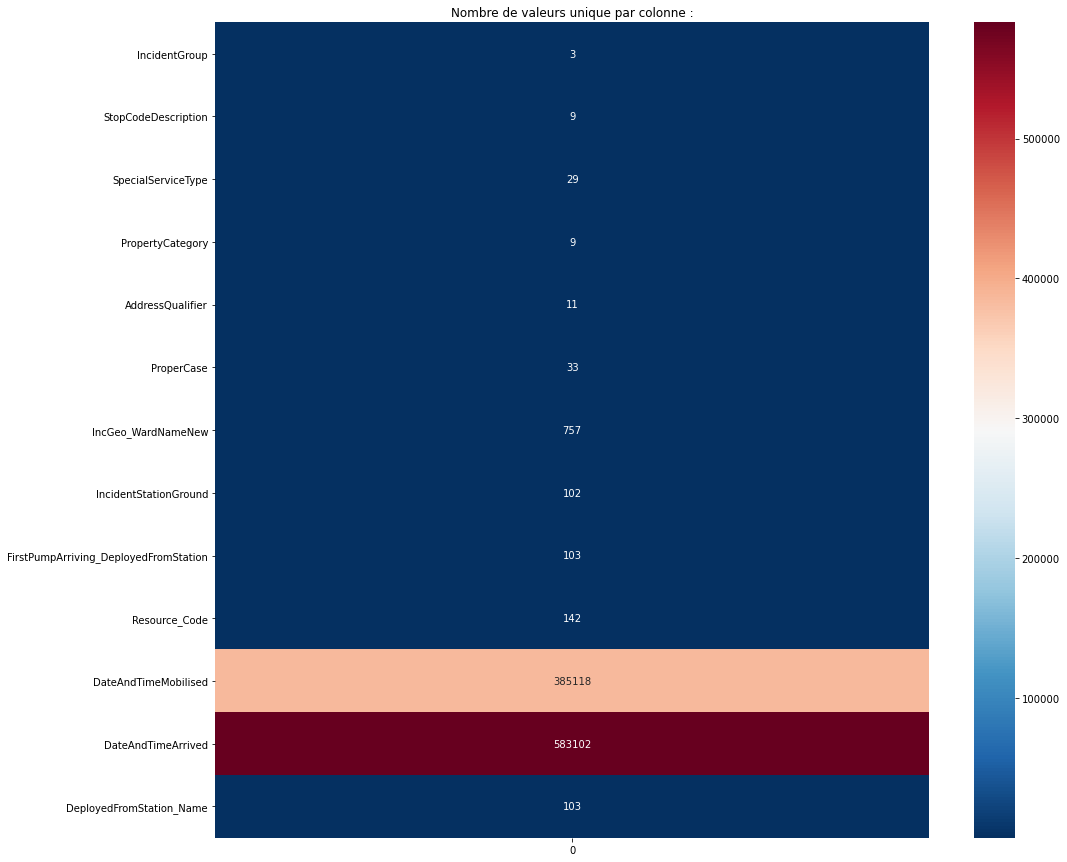

In [82]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [83]:
df_categorielle = df_categorielle.drop(["StopCodeDescription", "AddressQualifier", "IncGeo_WardNameNew"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

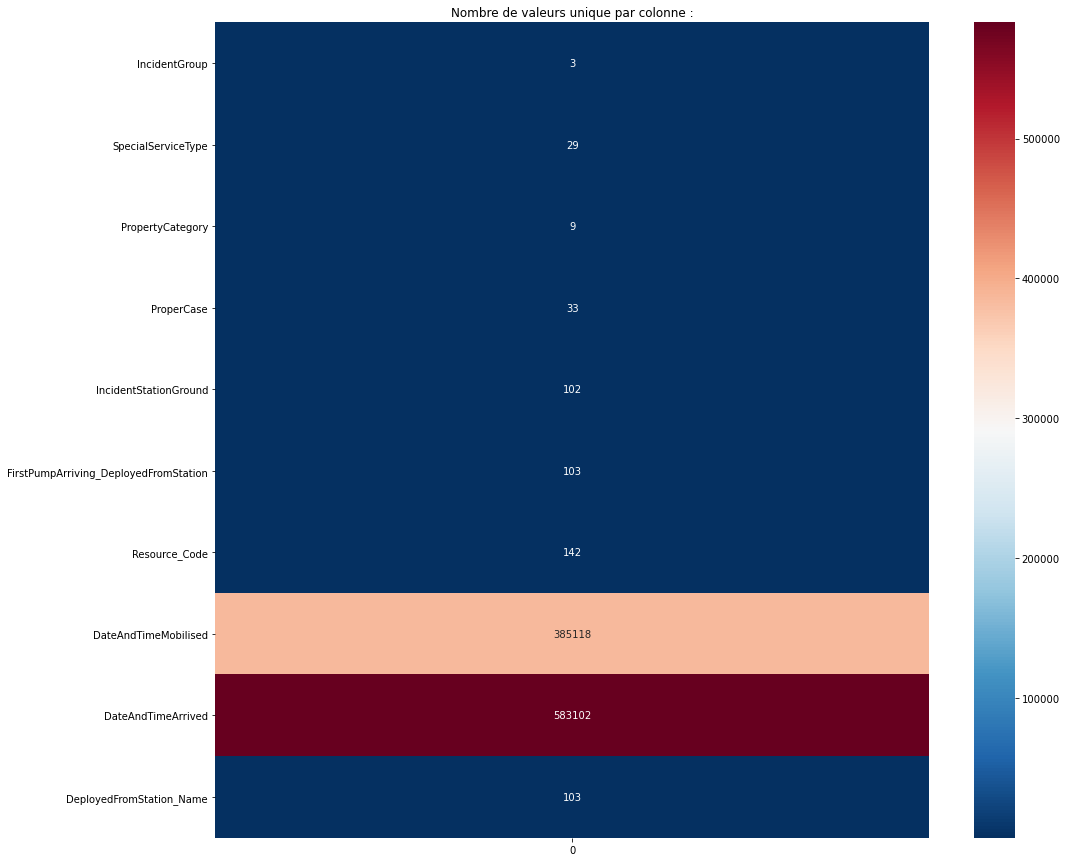

In [84]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [85]:
df_categorielle = df_categorielle.drop(["DateAndTimeMobilised", "DateAndTimeArrived", "FirstPumpArriving_DeployedFromStation"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

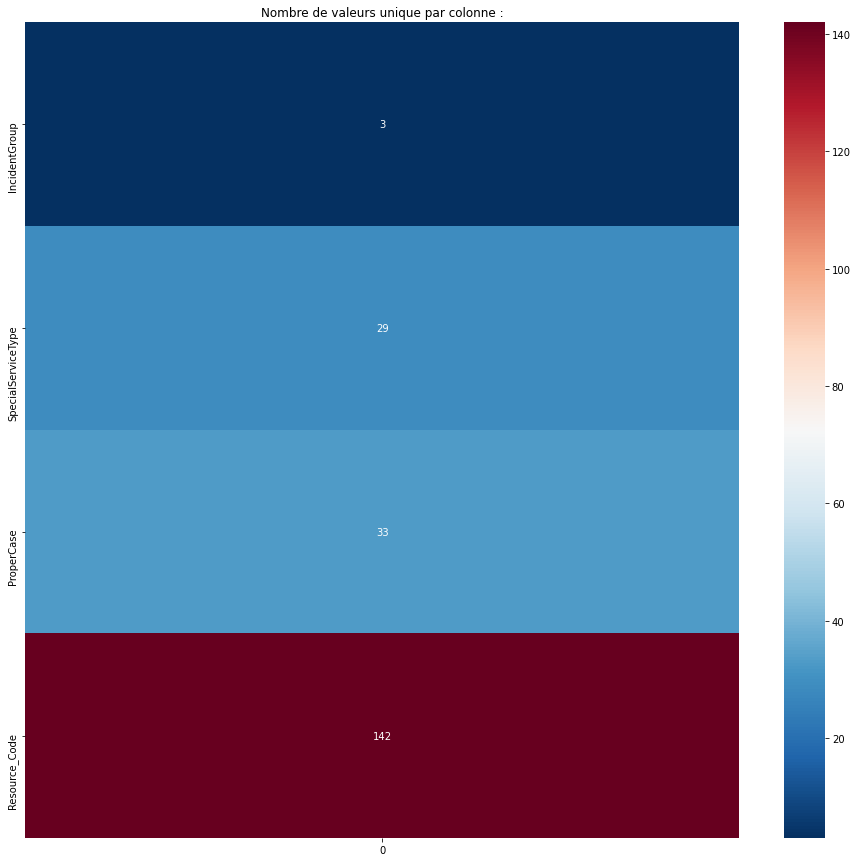

In [90]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [89]:
df_categorielle = df_categorielle.drop(["PropertyCategory", "DeployedFromStation_Name"], axis = 1)

In [91]:
# On encode les variables catégorielles
# Erreur de mémoire au lancement de la discrétisation
# Je suppose que cela peut venir des variables "DateAndTimeMobilised" et "DateAndTimeArrived"
df_categ_code = pd.get_dummies(df_categorielle)
df_categ_code.shape


(587073, 207)

In [92]:
# Du coup on décide de supprimer les 2 variables 
df_categorielle.head()
df_categorielle = df_categorielle.drop(["DateAndTimeMobilised", "DateAndTimeArrived"], axis = 1)

KeyError: "['DateAndTimeMobilised' 'DateAndTimeArrived'] not found in axis"

In [26]:
df_categorielle = df_categorielle.drop(["UPRN", "IncGeo_WardNameNew"], axis = 1)

KeyError: "['UPRN'] not found in axis"

KeyError: "['IncGeo_WardCode'] not found in axis"

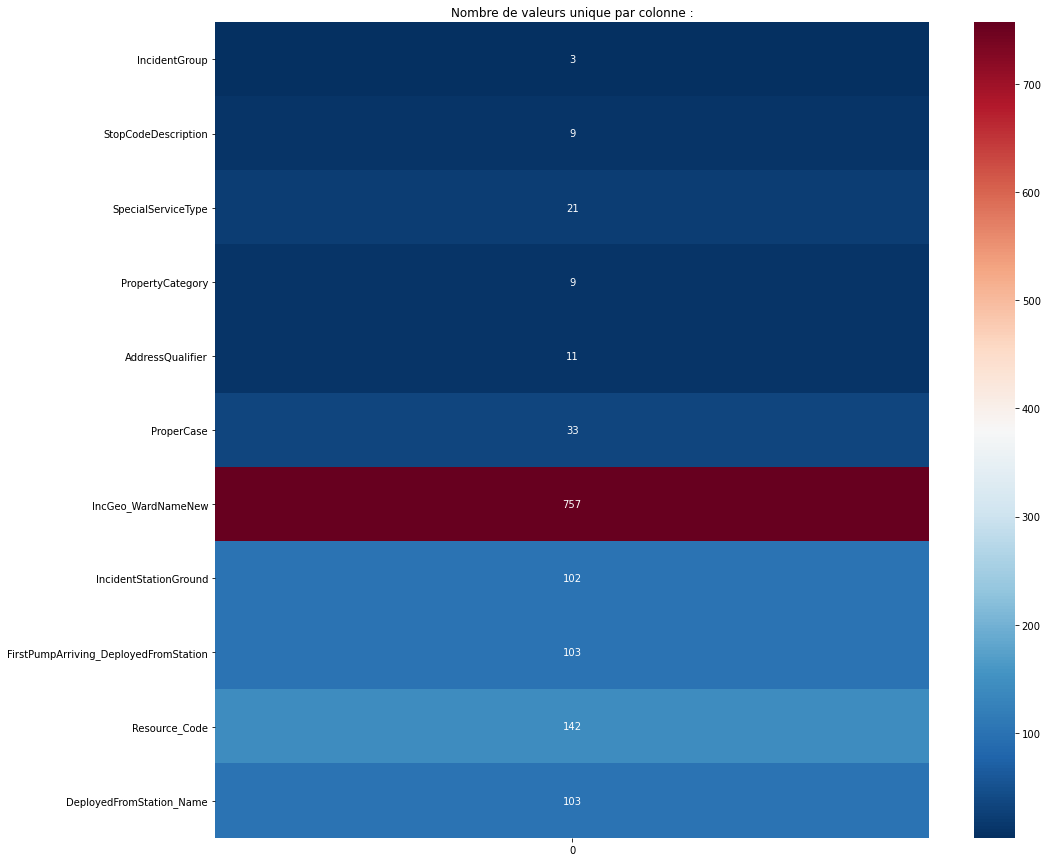

In [27]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')

df_categorielle = df_categorielle.drop(["IncGeo_WardCode"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

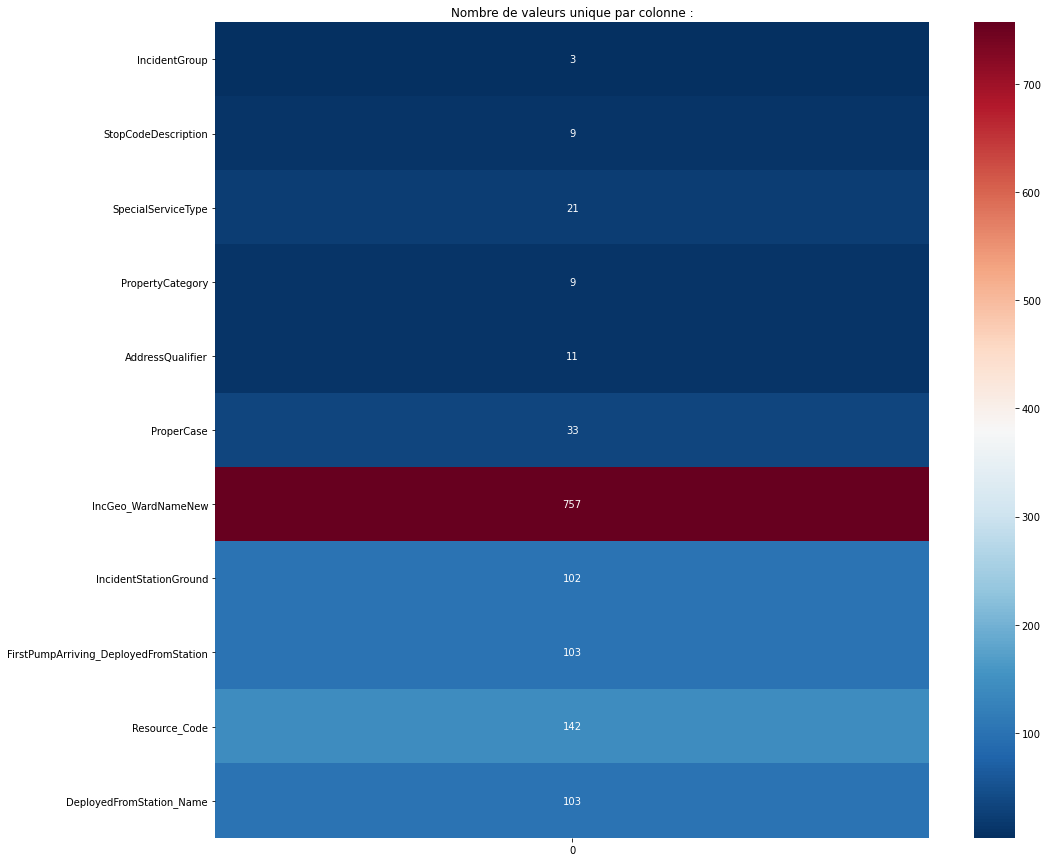

In [67]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [28]:
df_categorielle = df_categorielle.drop(["Resource_Code", "DeployedFromStation_Name", "FirstPumpArriving_DeployedFromStation", "IncidentStationGround", "IncGeo_WardNameNew"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

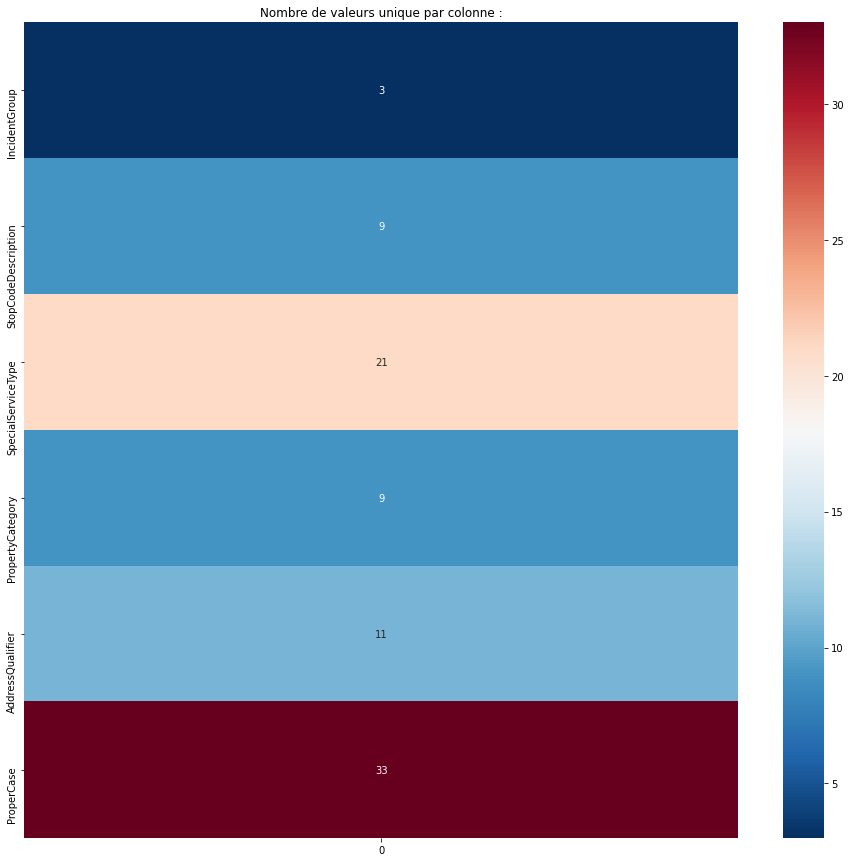

In [29]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [102]:
df_categ_code = pd.get_dummies(df_categorielle)
df_categ_code.shape


(587073, 207)

In [31]:
df_indicatrice = df_indicatrice(["CalYear_x", "USRN", "ResourceMobilisationId"], axis = 1)
df_indicatrice = df_indicatrice(["CalYear_y", "HourOfCall_y"], axis = 1)
df_indicatrice = df_indicatrice(["FirstPumpArriving_AttendanceTime", "SecondPumpArriving_AttendanceTime"], axis = 1)


TypeError: 'DataFrame' object is not callable

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

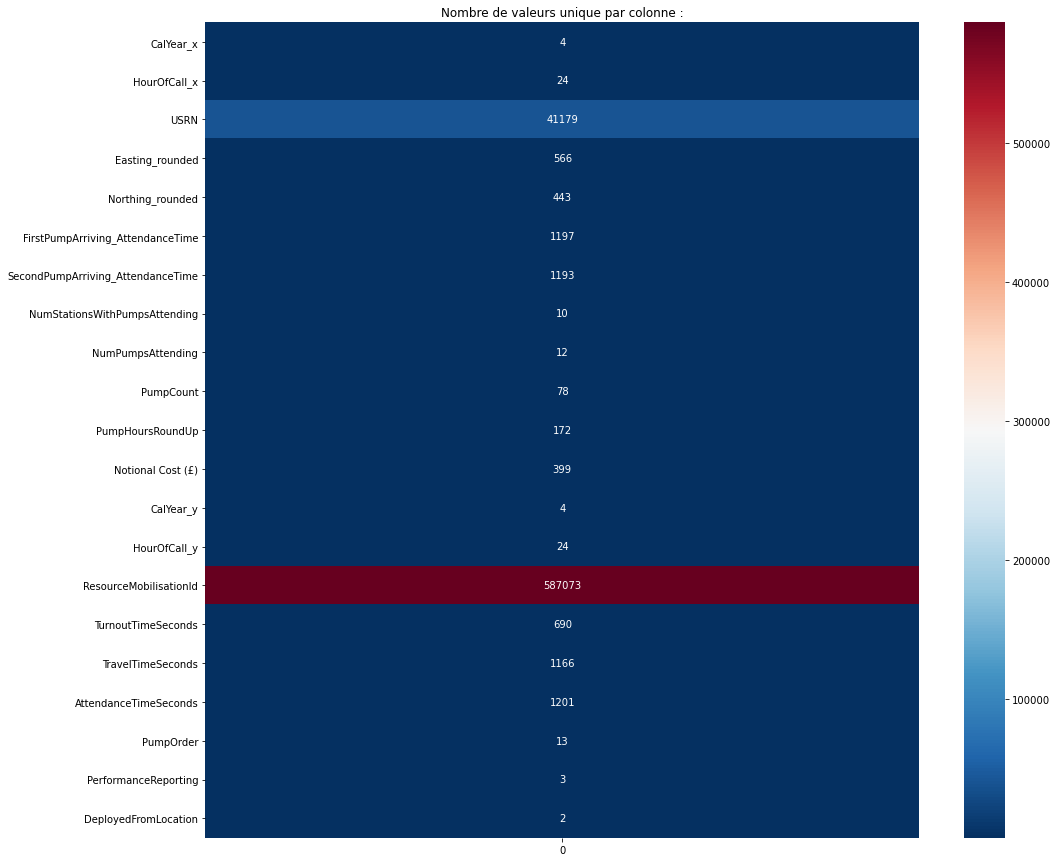

In [93]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [33]:
df_indicatrice[df_indicatrice["NumStationsWithPumpsAttending"] != df_indicatrice["NumPumpsAttending"]]

,CalYear_x,HourOfCall_x,USRN,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,...,Notional Cost (£),CalYear_y,HourOfCall_y,ResourceMobilisationId,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,PumpOrder,PerformanceReporting,DeployedFromLocation
24,2018,5,22502382,532050,178750,350.0,372.0,1.0,2.0,2.0,...,328.0,2018,5,5055381,107.0,243.0,350,1,1,0.0
25,2018,5,22502382,532050,178750,350.0,372.0,1.0,2.0,2.0,...,328.0,2018,5,5055380,130.0,242.0,372,2,2,0.0
28,2018,0,20602212,516650,180650,275.0,347.0,3.0,4.0,4.0,...,328.0,2018,0,5055180,88.0,187.0,275,1,1,0.0
29,2018,0,20602212,516650,180650,275.0,347.0,3.0,4.0,4.0,...,328.0,2018,0,5055181,82.0,265.0,347,2,2,0.0
30,2018,0,20602212,516650,180650,275.0,347.0,3.0,4.0,4.0,...,328.0,2018,0,5055182,67.0,346.0,413,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586948,2021,22,21103287,534750,189450,237.0,403.0,4.0,5.0,5.0,...,352.0,2021,22,5959271,59.0,346.0,405,4,0,0.0
586949,2021,22,21103287,534750,189450,237.0,403.0,4.0,5.0,5.0,...,352.0,2021,22,5959270,47.0,411.0,458,5,0,0.0
587031,2021,23,20901019,533750,184850,286.0,308.0,2.0,3.0,3.0,...,352.0,2021,23,5959300,79.0,207.0,286,1,1,0.0
587032,2021,23,20901019,533750,184850,286.0,308.0,2.0,3.0,3.0,...,352.0,2021,23,5959301,66.0,242.0,308,2,2,0.0


In [94]:
df_indicatrice = df_indicatrice.drop(["CalYear_x","CalYear_y","ResourceMobilisationId", "USRN","HourOfCall_y", "FirstPumpArriving_AttendanceTime","SecondPumpArriving_AttendanceTime"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

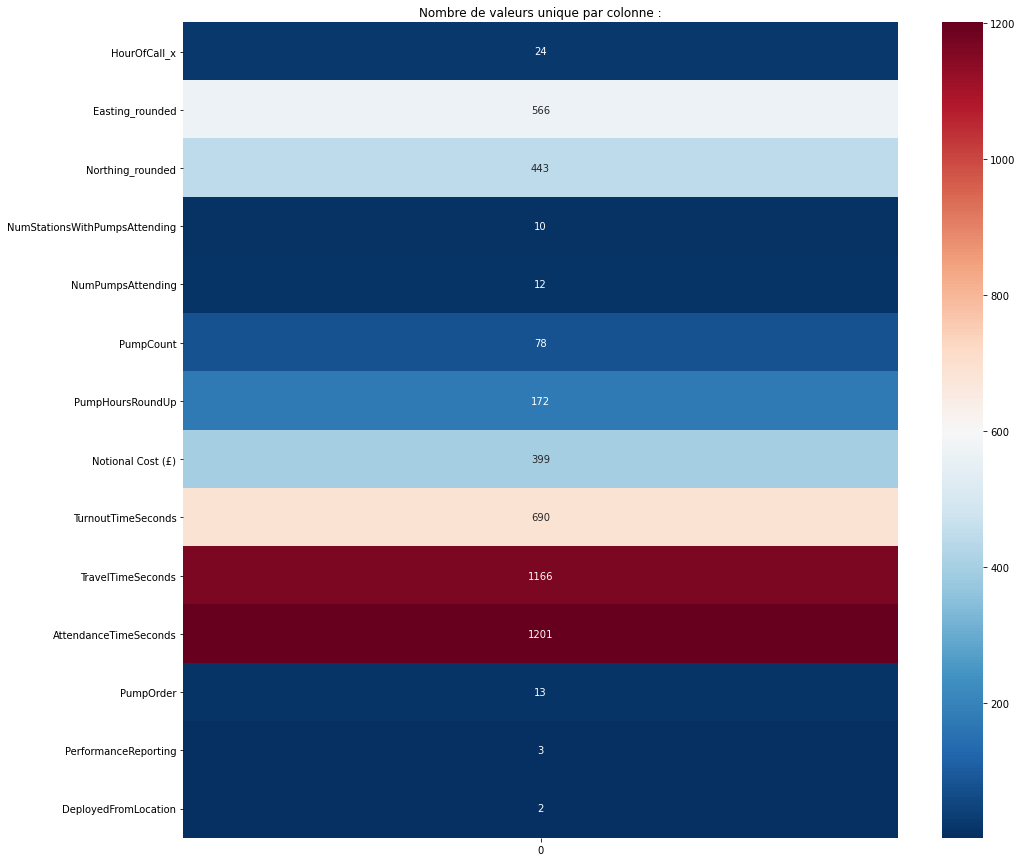

In [95]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [96]:
df_indicatrice = df_indicatrice.drop(["TravelTimeSeconds","TurnoutTimeSeconds", "Easting_rounded","Northing_rounded", "Notional Cost (£)"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

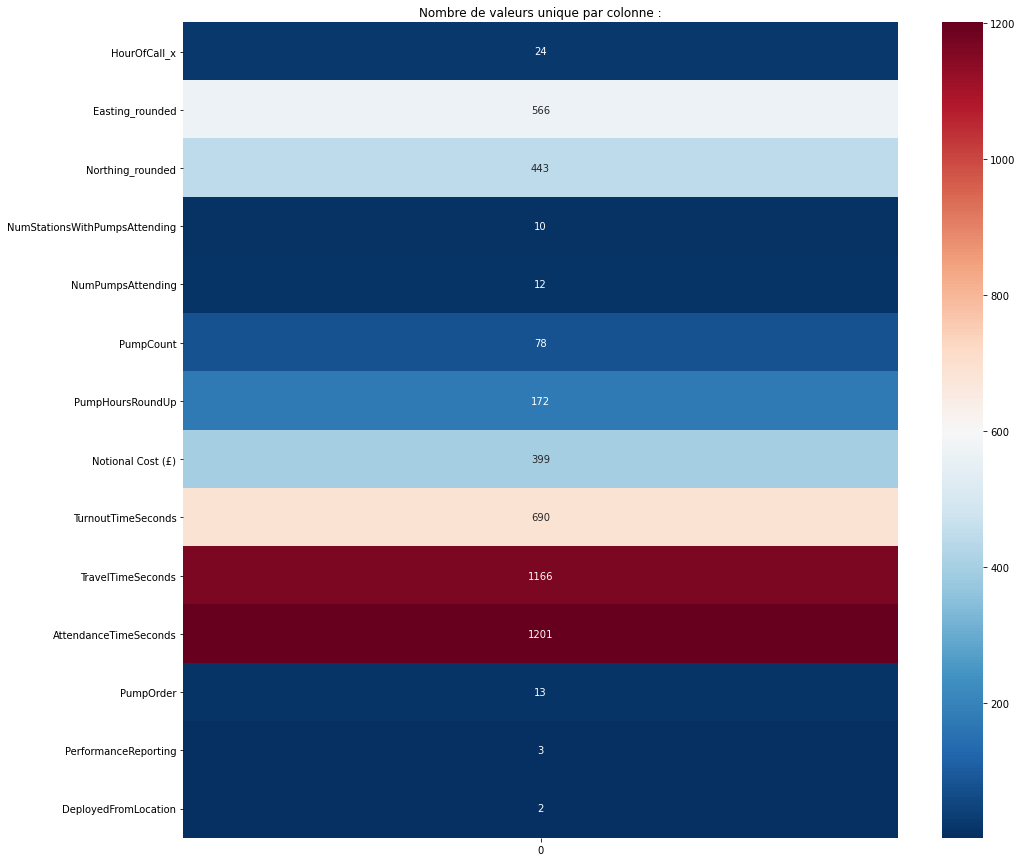

In [73]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [97]:
df_indicatrice = df_indicatrice.drop(["PumpCount", "PumpHoursRoundUp", "TravelTimeSeconds"], axis = 1)

KeyError: "['TravelTimeSeconds'] not found in axis"

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

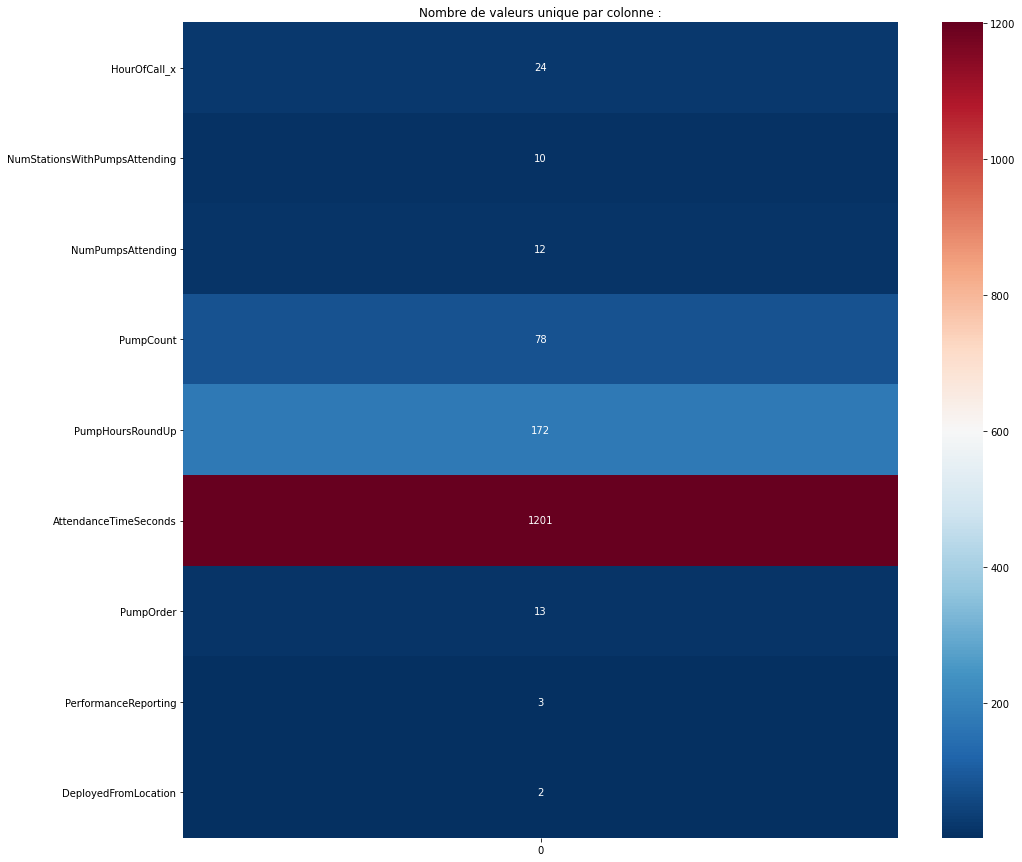

In [37]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [38]:
df_indicatrice = df_indicatrice.drop(["TurnoutTimeSeconds", "Notional Cost (£)", "Easting_rounded", "Northing_rounded"], axis = 1)

KeyError: "['TurnoutTimeSeconds' 'Notional Cost (£)' 'Easting_rounded'\n 'Northing_rounded'] not found in axis"

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

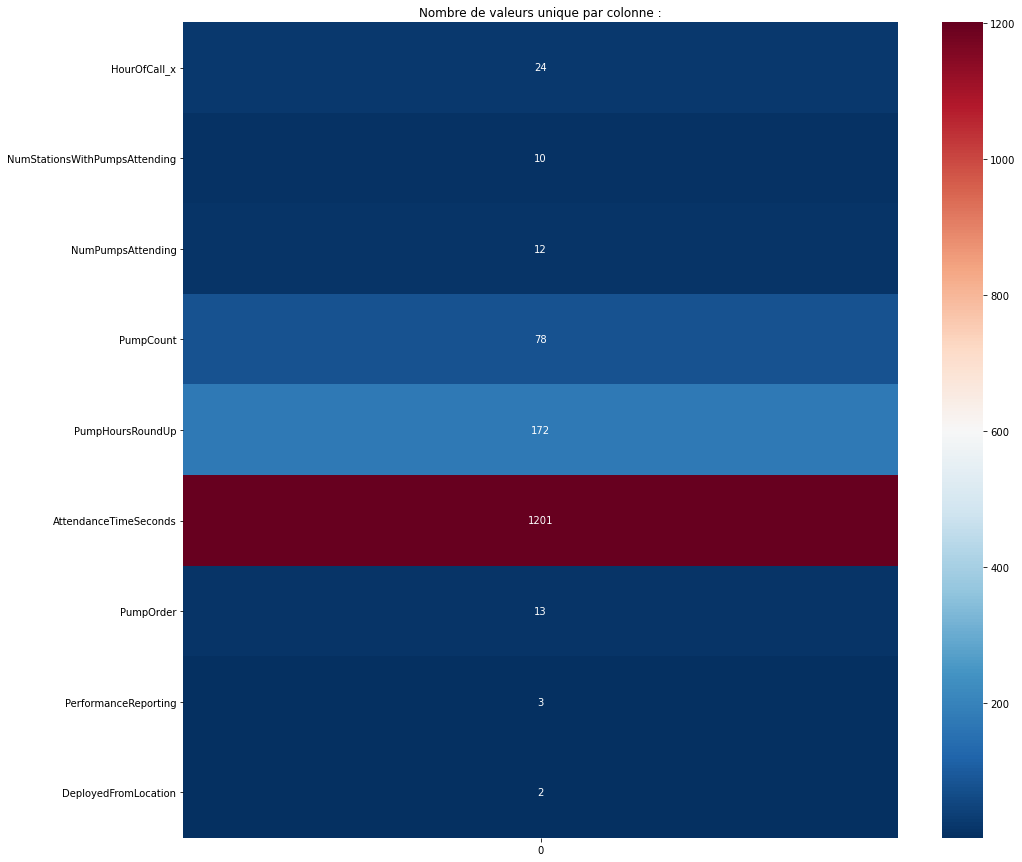

In [98]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [100]:
df_indicatrice = df_indicatrice.drop(["HourOfCall_x", "NumStationsWithPumpsAttending", "NumPumpsAttending", "PumpCount", "PumpHoursRoundUp", "PumpOrder"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

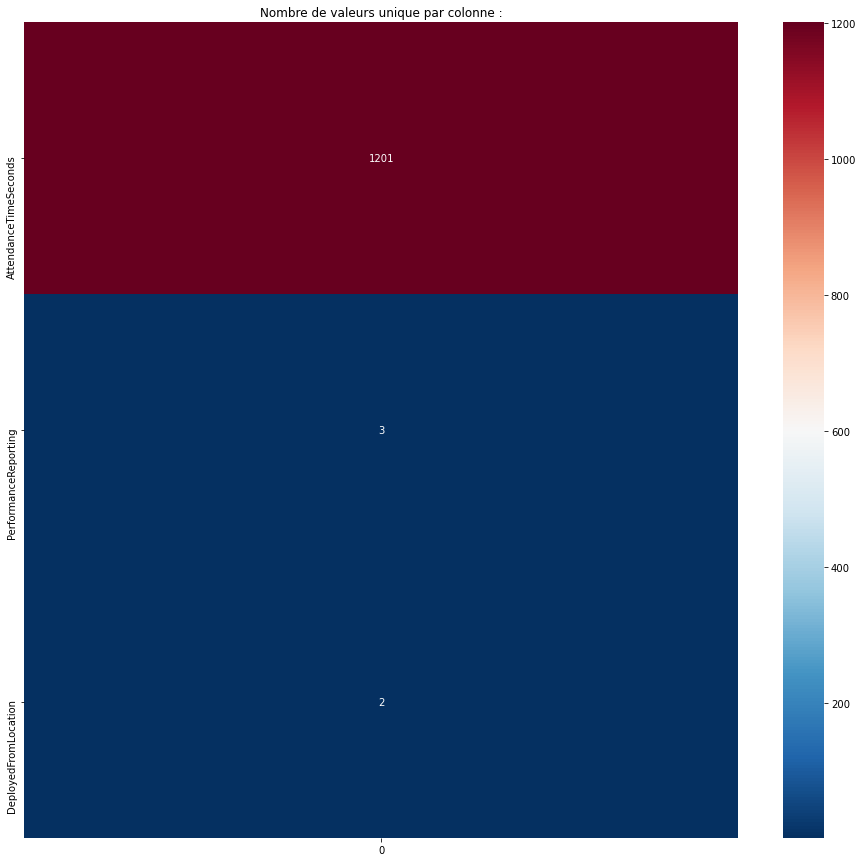

In [101]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [40]:
df_indicatrice.isna().sum()
df_indicatrice.dropna(subset=['DeployedFromLocation'],inplace=True)
df_indicatrice.isna().sum()

HourOfCall_x                       0
NumStationsWithPumpsAttending      0
NumPumpsAttending                  0
PumpCount                          0
PumpHoursRoundUp                 155
AttendanceTimeSeconds              0
PumpOrder                          0
PerformanceReporting               0
DeployedFromLocation               0
dtype: int64

In [103]:
df_categ_code.isna().sum()

IncidentGroup_False Alarm         0
IncidentGroup_Fire                0
IncidentGroup_Special Service     0
SpecialServiceType_AFA            0
SpecialServiceType_Advice Only    0
                                 ..
Resource_Code_H411                0
Resource_Code_H412                0
Resource_Code_H421                0
Resource_Code_H431                0
Resource_Code_H432                0
Length: 207, dtype: int64

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

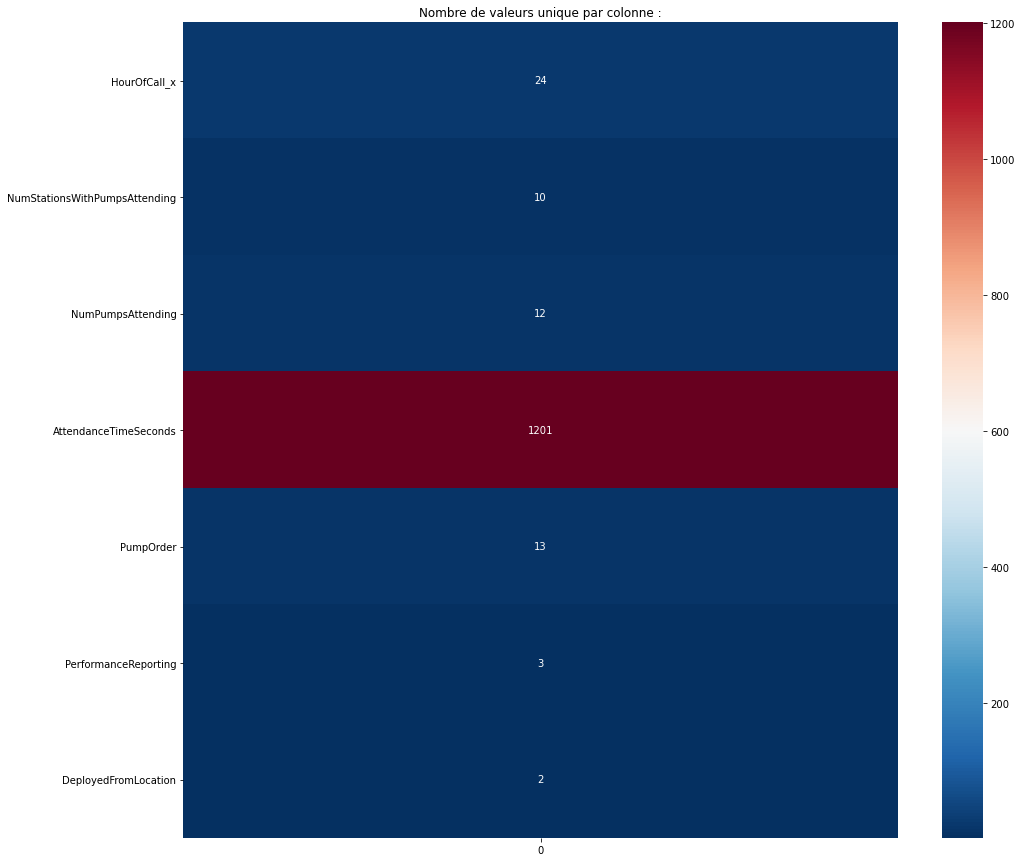

In [92]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [46]:
 
df_indicatrice = df_indicatrice.drop(["HourOfCall_x", "NumStationsWithPumpsAttending", "NumPumpsAttending", "PumpCount", "PumpHoursRoundUp"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

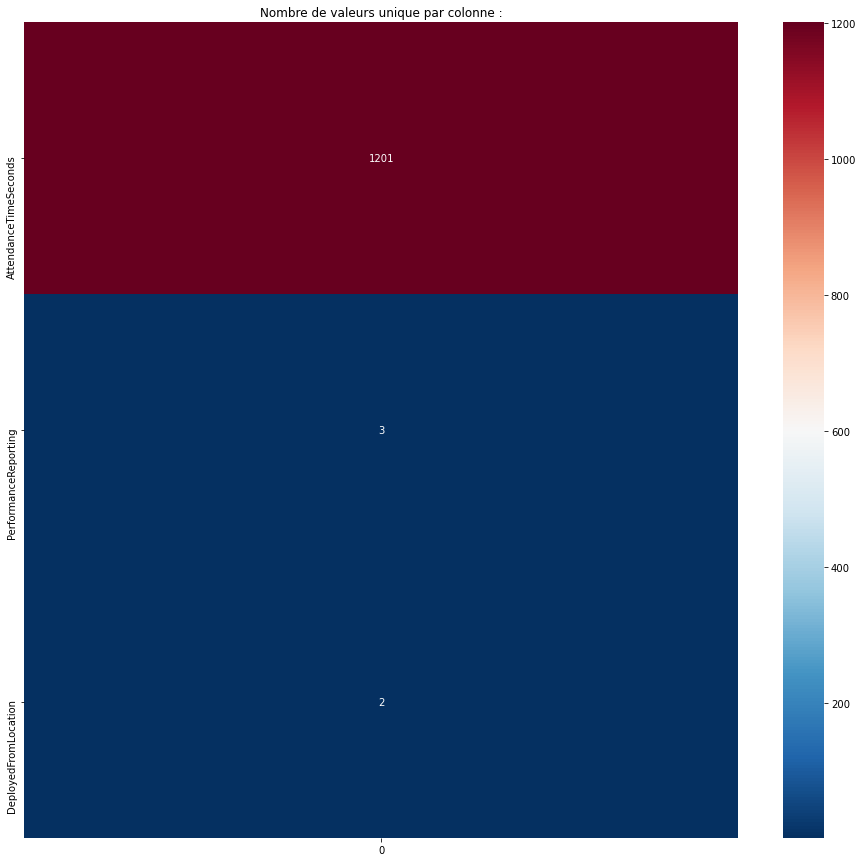

In [51]:
df_indicatrice = df_indicatrice.drop("PumpOrder", axis = 1)

plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [105]:
print(df_categ_code.isna().sum())
print(df_indicatrice.isna().sum())

df_indicatrice.dropna(subset=['DeployedFromLocation'],inplace=True)
df_indicatrice.isna().sum()

IncidentGroup_False Alarm         0
IncidentGroup_Fire                0
IncidentGroup_Special Service     0
SpecialServiceType_AFA            0
SpecialServiceType_Advice Only    0
                                 ..
Resource_Code_H411                0
Resource_Code_H412                0
Resource_Code_H421                0
Resource_Code_H431                0
Resource_Code_H432                0
Length: 207, dtype: int64
AttendanceTimeSeconds      0
PerformanceReporting       0
DeployedFromLocation     336
dtype: int64


AttendanceTimeSeconds    0
PerformanceReporting     0
DeployedFromLocation     0
dtype: int64

In [106]:
print(df_categ_code.isna().sum())
print(df_indicatrice.isna().sum())

IncidentGroup_False Alarm         0
IncidentGroup_Fire                0
IncidentGroup_Special Service     0
SpecialServiceType_AFA            0
SpecialServiceType_Advice Only    0
                                 ..
Resource_Code_H411                0
Resource_Code_H412                0
Resource_Code_H421                0
Resource_Code_H431                0
Resource_Code_H432                0
Length: 207, dtype: int64
AttendanceTimeSeconds    0
PerformanceReporting     0
DeployedFromLocation     0
dtype: int64


Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

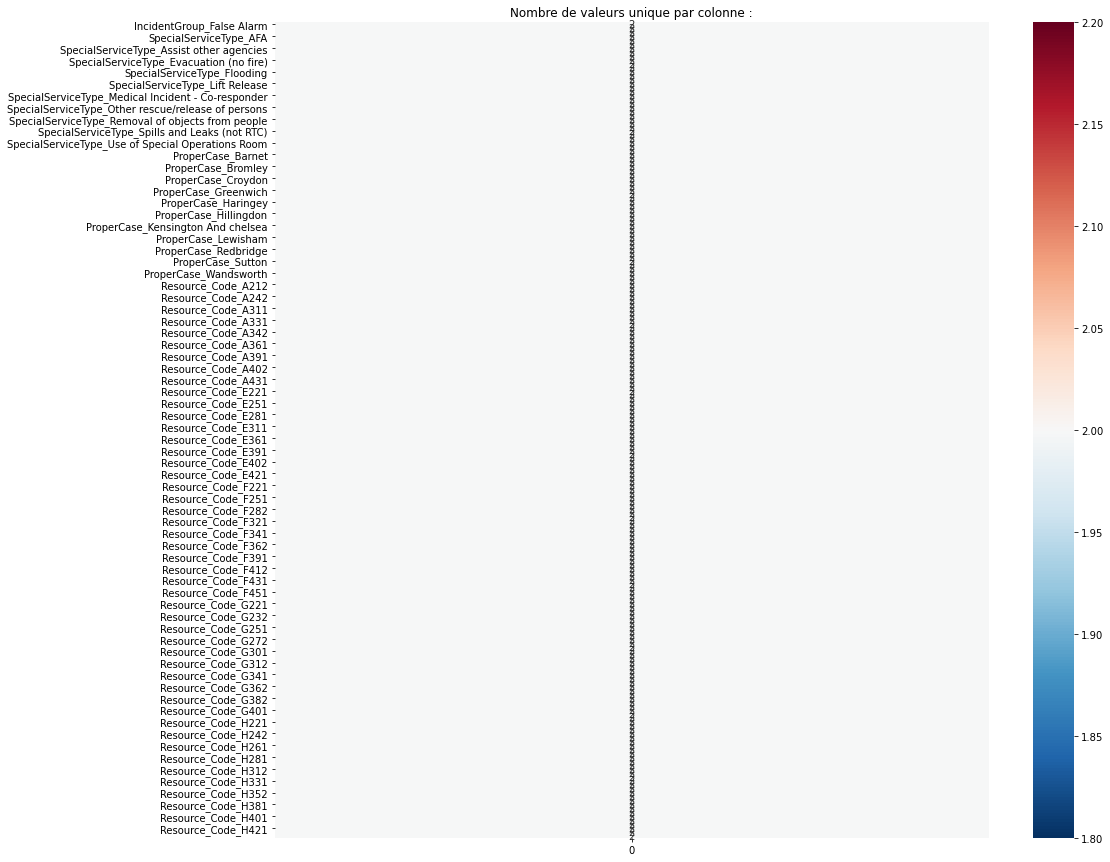

In [107]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categ_code.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [108]:
print(df_categorielle.isna().sum())
print(df_indicatrice.isna().sum())

IncidentGroup         0
SpecialServiceType    0
ProperCase            0
Resource_Code         0
dtype: int64
AttendanceTimeSeconds    0
PerformanceReporting     0
DeployedFromLocation     0
dtype: int64


In [55]:
df_categorielle['SpecialServiceType']=df_categorielle['SpecialServiceType'].fillna(df_categorielle['StopCodeDescription'])
df_categorielle = df_categorielle.drop(["StopCodeDescription", "AddressQualifier"], axis = 1)

df_categorielle["SpecialServiceType"].isna().sum()

#df_categorielle["AddressQualifier","ProperCase"].head()

df_categ_code = pd.get_dummies(df_categorielle)
df_categ_code.shape

KeyError: 'StopCodeDescription'

In [ ]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categ_code.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.9)
pca.fit(df_categ_code)
print("Nombre de composantes retenues :", pca.n_components_)

Nombre de composantes retenues : 33


In [109]:
from sklearn.preprocessing import StandardScaler

#df_indicatrice = df_indicatrice.drop(["TravelTimeSeconds","TurnoutTimeSeconds","PumpHoursRoundUp"], axis = 1)

df_merge = pd.concat([df_indicatrice, df_categ_code], axis = 1)

#standardscaler sur les données trop haute
#sc = StandardScaler()
#df_merge[['Easting_rounded', 'Northing_rounded', 'Notional Cost (£)']] = sc.fit_transform(df_merge[['Easting_rounded', 'Northing_rounded', 'Notional Cost (£)']])


Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

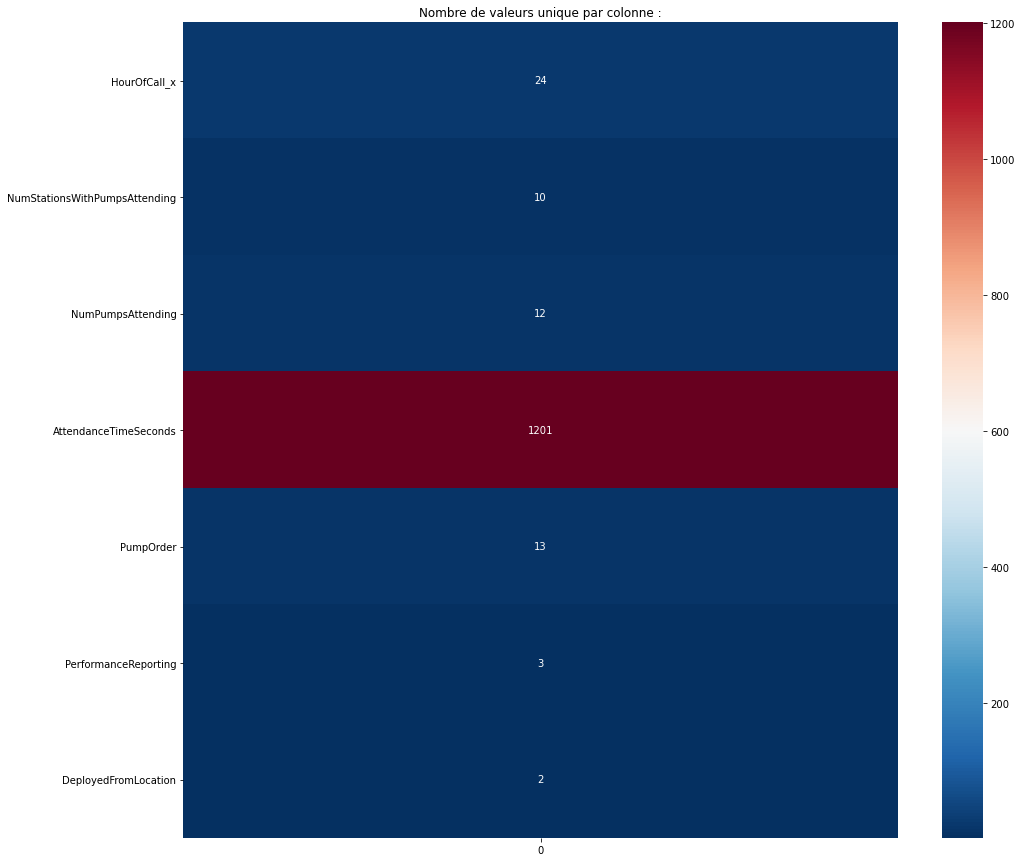

In [80]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [115]:
df_merge.isna().sum()
df_merge.dropna(subset=['DeployedFromLocation', 'PerformanceReporting', 'AttendanceTimeSeconds'],inplace=True)
df_merge.isna().sum()

AttendanceTimeSeconds        0
PerformanceReporting         0
DeployedFromLocation         0
IncidentGroup_False Alarm    0
IncidentGroup_Fire           0
                            ..
Resource_Code_H411           0
Resource_Code_H412           0
Resource_Code_H421           0
Resource_Code_H431           0
Resource_Code_H432           0
Length: 210, dtype: int64

In [116]:
# Séparation de la variable cible du reste des autres variables
target = df_merge.AttendanceTimeSeconds
data = df_merge.drop('AttendanceTimeSeconds', axis=1)

# Séparation des données en un ensemble d'apprentissage et un ensemble de Test 
# avec 20% des données originales pour le Test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)


In [117]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [118]:
print(X_train.isna().sum()/len(df_merge)*100)
print(y_train.isna().sum()/len(df_merge)*100)


PerformanceReporting             0.0
DeployedFromLocation             0.0
IncidentGroup_False Alarm        0.0
IncidentGroup_Fire               0.0
IncidentGroup_Special Service    0.0
                                ... 
Resource_Code_H411               0.0
Resource_Code_H412               0.0
Resource_Code_H421               0.0
Resource_Code_H431               0.0
Resource_Code_H432               0.0
Length: 209, dtype: float64
0.0


In [119]:
# Création d'un modèle de régression linéaire simple pour expliquer le délai en fonction de la variable SpecialServiceType
# à partir de l'ensemble d'entrainement
linearModel = LinearRegression()
linearModel.fit(X_train_pca, y_train)

# Affchage du score R² et RMSE du modèle sur l'échantillon d'entrainement puis sur celui du test
print('score train :', linearModel.score(X_train_pca, y_train))
print('score test :', linearModel.score(X_test_pca, y_test))

score train : 0.04576139349939656
score test : 0.04683968250755599
